# Data Labelling

This notebook will process the crawled Farfetch data and prepare all data needed for training.

The objectives are to define the similarity **conditions** and sample the **triplets** `(anchor, negative, positive)`. There are 8 conditions in total:
- color
- pattern
- fabric
- collar
- sleeve
- length
- hem
- fit

For each condition, I created a list of **labels** that a product can possess (e.g. black in color, short sleeves, slim fit). The list is modified based on the [DeepFashion Attribute Prdiction](https://mmlab.ie.cuhk.edu.hk/projects/DeepFashion/AttributePrediction.html) dataset and by examination of the Farfetch product descriptions.

Thanks to Farfetch website being well annotated, I am able to extract the labels by simple keyword matching.

*Figure 1: Product description section on Farfetch website*
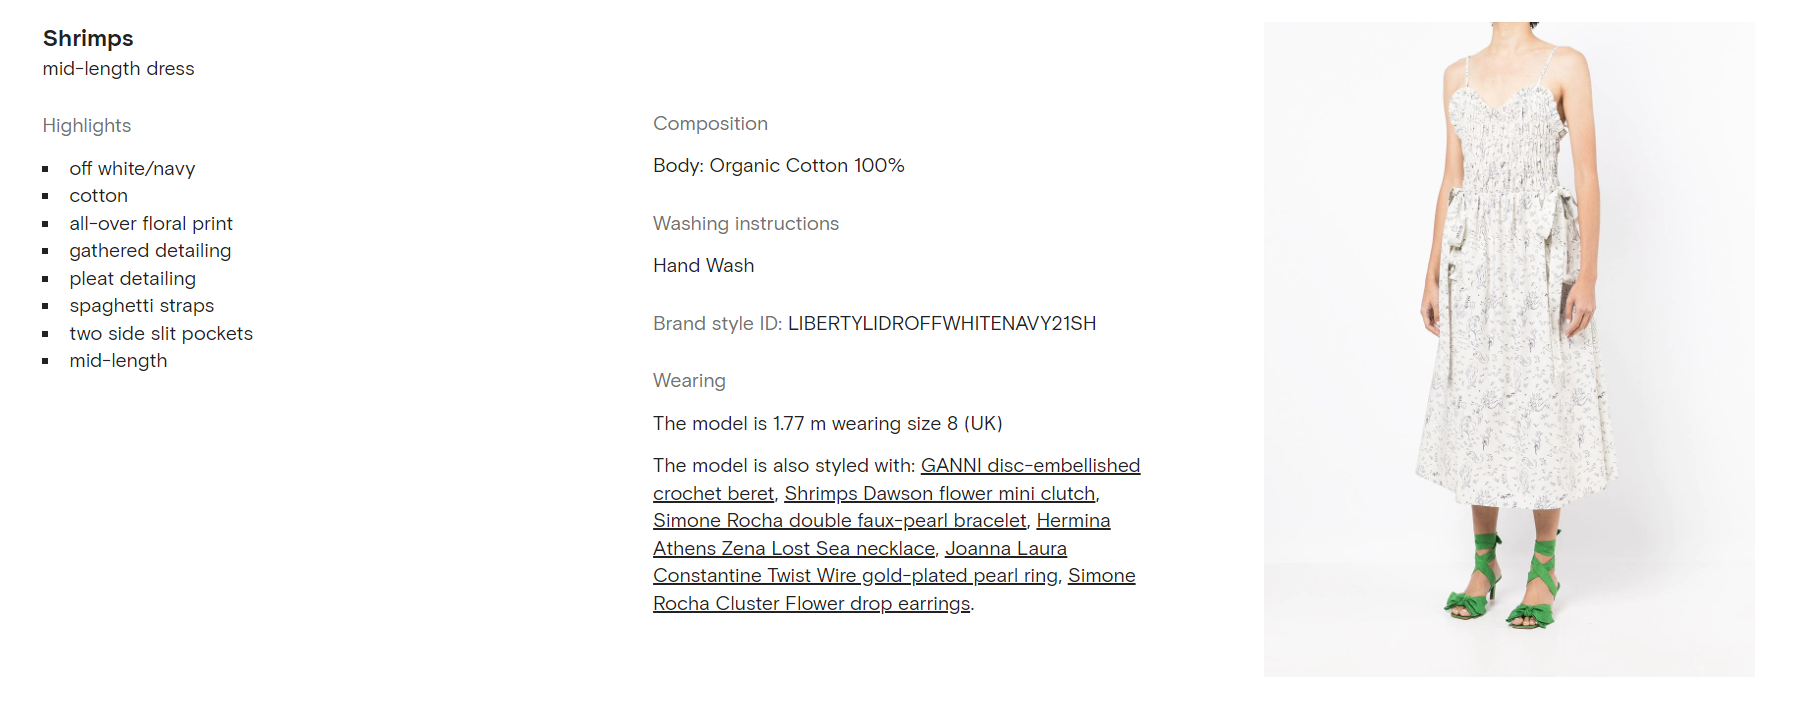

In [1]:
import os
import math
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from functools import reduce

from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import regex

First, we load the crawled data

In [2]:
gender = "women"
category = "dresses-1"
df = pd.read_csv(f"./{gender}-{category}.csv")
df.head()

,gender,category,product_id,name,brand,url,product_desc,image
0,women,dresses-1,18093545,floral-print pleated georgette midi dress,GANNI,https://www.farfetch.com/hk/shopping/women/gan...,. . ganni . floral-print pleated georgette mid...,https://cdn-images.farfetch-contents.com/18/09...
1,women,dresses-1,17229007,open-back slip dress,Nanushka,https://www.farfetch.com/hk/shopping/women/nan...,. . nanushka . open-back slip dress . highligh...,https://cdn-images.farfetch-contents.com/17/22...
2,women,dresses-1,18310269,floral-print sweetheart neck dress,Reformation,https://www.farfetch.com/hk/shopping/women/ref...,. . reformation . floral-print sweetheart neck...,https://cdn-images.farfetch-contents.com/18/31...
3,women,dresses-1,16260247,embroidered logo T-shirt dress,Marine Serre,https://www.farfetch.com/hk/shopping/women/mar...,. . marine serre . embroidered logo t-shirt dr...,https://cdn-images.farfetch-contents.com/16/26...
4,women,dresses-1,17786874,3D jacquard warp dress,GANNI,https://www.farfetch.com/hk/shopping/women/gan...,. . ganni . 3d jacquard warp dress. highlights...,https://cdn-images.farfetch-contents.com/17/78...


# Text cleaning

As we are doing simple keyword matching, we need to clean and stem the product description.

In [3]:
stemmer = SnowballStemmer("english")

def stemming(text):
    tokens = word_tokenize(text)
    stemmed = [stemmer.stem(token) for token in tokens]
    return " ".join(stemmed)

def clean_text(text):
    text = regex.sub(r"<.*>+", " ", text)
    text = regex.sub(r"'s", " ", text)
    text = regex.sub(r"-", " ", text)
    text = regex.sub(r"\.", " ", text)
    text = regex.sub(r"[^\p{Latin} 0-9/]", u"", text)
    text = regex.sub(r"\s+", " ", text)
    text = text.strip().lower()
    return text

df["text"] = df[["name", "product_desc"]].fillna("").apply(lambda row: " ".join(row.tolist()), axis=1)
df["text"] = df["text"].apply(clean_text).apply(stemming)

df.head()

,gender,category,product_id,name,brand,url,product_desc,image,text
0,women,dresses-1,18093545,floral-print pleated georgette midi dress,GANNI,https://www.farfetch.com/hk/shopping/women/gan...,. . ganni . floral-print pleated georgette mid...,https://cdn-images.farfetch-contents.com/18/09...,floral print pleat georgett midi dress ganni f...
1,women,dresses-1,17229007,open-back slip dress,Nanushka,https://www.farfetch.com/hk/shopping/women/nan...,. . nanushka . open-back slip dress . highligh...,https://cdn-images.farfetch-contents.com/17/22...,open back slip dress nanushka open back slip d...
2,women,dresses-1,18310269,floral-print sweetheart neck dress,Reformation,https://www.farfetch.com/hk/shopping/women/ref...,. . reformation . floral-print sweetheart neck...,https://cdn-images.farfetch-contents.com/18/31...,floral print sweetheart neck dress reform flor...
3,women,dresses-1,16260247,embroidered logo T-shirt dress,Marine Serre,https://www.farfetch.com/hk/shopping/women/mar...,. . marine serre . embroidered logo t-shirt dr...,https://cdn-images.farfetch-contents.com/16/26...,embroid logo t shirt dress marin serr embroid ...
4,women,dresses-1,17786874,3D jacquard warp dress,GANNI,https://www.farfetch.com/hk/shopping/women/gan...,. . ganni . 3d jacquard warp dress. highlights...,https://cdn-images.farfetch-contents.com/17/78...,3d jacquard warp dress ganni 3d jacquard warp ...


# Keyword Matching

This is the manually prepared list of keywords used for extracting the product labels.

Each row represents a label. The `condition` column represents the condition of the label. There are also many variants of the same label that can be considered "similar" in the context of image retrieval (by subjective standard). For example, if our query dress is blue in colour, it is acceptable to retrieve a navy dress. Thus, we also include several synonyms (`syn0` to `syn5`) for matching to the same label.

In [4]:
keywords = pd.read_csv("../data/farfetch/keywords.csv")
keywords = keywords.fillna("")
keywords

,condition,label,syn0,syn1,syn2,syn3,syn4,syn5
0,color,white,beige,off white,,,,
1,color,black,,,,,,
2,color,blue,purple,navy,indigo,violet,,
3,color,brown,tan,,,,,
4,color,green,olive,lime,,,,
...,...,...,...,...,...,...,...,...
95,hem,fringed hem,,,,,,
96,fit,relaxed fit,loose fit,comfortable fit,wide fit,,,
97,fit,straight fit,regular fit,,,,,
98,fit,slim fit,stretch fit,restrictive fit,skinny fit,,,


Here, we create some mappings for later use.

In [5]:
keyword_to_label = {}

for _, row in keywords.drop(columns="condition").iterrows():
    values = row.values
    for synonym in values:
        if synonym:
            keyword_to_label[stemming(synonym)] = values[0]
            
keyword_set = set(list(keyword_to_label.keys()))

In [6]:
label_to_condition = keywords.set_index("label")["condition"].to_dict()
condition_to_labels = keywords.groupby("condition")["label"].apply(set).to_dict()

Here, we match the keywords in the product description.

First, we extract the unigrams & bigrams in the text, then do a simple set intersection to extract any matched labels, and save to the `product_to_keywords` mapping.

In [7]:
product_to_keywords = []

def match_keywords(product_id, text):
    bigrams = set([" ".join(b) for b in zip(text.split(" ")[:-1], text.split(" ")[1:])])
    unigrams = set(text.split(" "))
    matched_keywords = (bigrams & keyword_set) | (unigrams & keyword_set)
    product_to_keywords.extend([(product_id, keyword_to_label[kw], label_to_condition[keyword_to_label[kw]]) for kw in matched_keywords])
    
for product_id, text in tqdm(df[["product_id", "text"]].values, total=len(df)):
    match_keywords(product_id, text)

  0%|          | 0/9000 [00:00<?, ?it/s]

Let's see what we have extracted.

Notice, here, some labels are pretty rare and are only present in a handful of products. These labels are not useful for triplet sampling as the pool is too small. So we filter out any labels that are present in less than 20 products.

In [8]:
product_labels = pd.DataFrame(product_to_keywords, columns=["product_id", "label", "condition"])

# filter out low frequency labels
vc = product_labels["label"].value_counts()
vc = vc[vc >= 20]

product_labels = product_labels[product_labels["label"].isin(set(vc.index))]
product_labels.to_csv("../data/farfetch/product_labels.csv", index=False)
product_labels

,product_id,label,condition
0,18093545,floral,pattern
1,18093545,v neck,collar
2,18093545,v neck,collar
3,18093545,midi,length
4,18093545,midi,length
...,...,...,...
43273,18174678,sweetheart,collar
43274,18174678,black,color
43275,18174678,silver,color
43276,18174678,cotton,fabric


Let's make sure that each condition has sufficiently diverse labels

In [9]:
product_labels.drop_duplicates(["condition", "label"])["condition"].value_counts()

fabric     20
color      12
pattern    10
sleeve      9
collar      8
hem         8
length      4
fit         3
Name: condition, dtype: int64

Save our product list to file

In [10]:
product_ids = product_labels["product_id"].unique()
np.savetxt(f"../data/farfetch/product_ids.txt", product_ids, fmt='%i', delimiter=" ")
print(f"num products: {len(product_ids)}")

num products: 6390


In [11]:
# mapping of product id to integer index
product_id_to_idx = {k: i for i, k in enumerate(product_ids)}

# Triplets Sampling

Split the products into train, val & test sets, so that each dataset has a disjoint set of products (in accordance with the paper).

For each split & each condition, we will sample `N` triplets in the form of `(anchor, negative, positive)`. 
- The anchor and positive products will possess the same label in that condition (e.g. in `color` condition, anchor has `black` and `red`, positive has `black` and `white`). 
- The anchor and negative products will have no common label in that condition (e.g. anchor has `black` and `red`, negative has `blue` and `white`).

In [12]:
conditions = np.sort(product_labels["condition"].unique())
np.savetxt(f"../data/farfetch/conditions.txt", conditions, fmt='%s', delimiter=" ")
conditions

array(['collar', 'color', 'fabric', 'fit', 'hem', 'length', 'pattern',
       'sleeve'], dtype=object)

In [13]:
triplets_dir = "../data/farfetch/triplets"
os.makedirs(triplets_dir, exist_ok=True)

In [14]:
products_train, products_other = train_test_split(product_ids, test_size=1000, random_state=1)
products_val, products_test = train_test_split(products_other, test_size=500, random_state=1)

In [15]:
# split, products, desired num triplets to sample (N)
# for speed, we will sample N triplets and filter out invalid ones
# so the resultant triplets will be less than N
splits = [
    ("train", products_train, 80000),
    ("val", products_val, 10000),
    ("test", products_test, 10000),
]

for split, products, N in splits:
    print(f"Split: {split}")
    
    for i, condition in enumerate(conditions):
        print(f"condition [{i+1}/{len(conditions)}]: {condition}")

        # get data by condition
        data = product_labels[(product_labels["condition"] == condition) & (product_labels["product_id"].isin(products))].copy()
        label_to_products = data.groupby("label")["product_id"].apply(set).to_dict()

        if len(data) == 0:
            print("empty df")
            continue

        # target number of triplets per label
        labels = data["label"].unique()
        n_per_label = math.ceil(N / len(labels))

        if len(labels) <= 1:
            print(f"too few labels ({len(labels)})")
            continue

        # sample triplets
        dfs = []
        for i, label in enumerate(labels):

            # positive pool
            pos_pool = label_to_products[label]
            # negative pool, same attr_type but different attr
            neg_labels = condition_to_labels[label_to_condition[label]] - {label}
            neg_pools = [label_to_products.get(a, set()) for a in neg_labels]
            neg_pool = reduce(lambda a, b: a | b, neg_pools)
            neg_pool = neg_pool - pos_pool

            pos_pool = np.array(list(pos_pool))
            neg_pool = np.array(list(neg_pool))

            # sample i, j, l (anchor, negative, positive)
            pool_i = np.random.choice(pos_pool, n_per_label, replace=True)
            pool_j = np.random.choice(neg_pool, n_per_label, replace=True)
            pool_l = np.random.choice(pos_pool, n_per_label, replace=True)

            _df = pd.DataFrame({
                "anchor": pool_i,
                "neg": pool_j,
                "pos": pool_l,
            })
            _df = _df[(_df["anchor"] != _df["neg"]) & (_df["anchor"] != _df["pos"])]

            dfs.append(_df)

        triplets = pd.concat(dfs)

        # map product id to index
        triplets["anchor"] = triplets["anchor"].apply(lambda a: product_id_to_idx[a])
        triplets["neg"] = triplets["neg"].apply(lambda a: product_id_to_idx[a])
        triplets["pos"] = triplets["pos"].apply(lambda a: product_id_to_idx[a])
        triplets = triplets[["anchor", "pos", "neg"]].drop_duplicates()
        triplets = triplets.values.astype(int)
        
        print(f"\tsplit={split} test={len(triplets)}")

        np.savetxt(f"{triplets_dir}/{condition.lower().replace(' ', '_')}_{split}.txt", triplets, fmt='%i', delimiter=" ")

Split: train
condition [1/8]: collar
	split=train test=79110
condition [2/8]: color
	split=train test=79300
condition [3/8]: fabric
	split=train test=78248
condition [4/8]: fit
	split=train test=44153
condition [5/8]: hem
	split=train test=78385
condition [6/8]: length
	split=train test=79911
condition [7/8]: pattern
	split=train test=77132
condition [8/8]: sleeve
	split=train test=78270
Split: val
condition [1/8]: collar
	split=val test=7106
condition [2/8]: color
	split=val test=9207
condition [3/8]: fabric
	split=val test=7570
condition [4/8]: fit
	split=val test=24
condition [5/8]: hem
	split=val test=6885
condition [6/8]: length
	split=val test=9845
condition [7/8]: pattern
	split=val test=5857
condition [8/8]: sleeve
	split=val test=7591
Split: test
condition [1/8]: collar
	split=test test=8791
condition [2/8]: color
	split=test test=8923
condition [3/8]: fabric
	split=test test=7347
condition [4/8]: fit
	split=test test=108
condition [5/8]: hem
	split=test test=7513
condition [6